# FLDetector for MNIST with Fang/Dirichlet distributions

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

/tmp/ipykernel_1032510/912229180.py:1: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


In [2]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
import torch.optim as optim
from torch.autograd import Variable
import numpy as np
import random
import copy
import time
from functools import reduce

import os
import sys
import pickle
sys.path.insert(0,'./utils/')
from logger import *
from eval import *
from misc import *

from sklearn.metrics import roc_auc_score
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from collections import defaultdict

from SGD import *
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device)

/work/vshejwalkar_umass_edu/anaconda/envs/myenv/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: /work/vshejwalkar_umass_edu/anaconda/envs/myenv/lib/python3.10/site-packages/torchvision/image.so: undefined symbol: _ZN2at4_ops19empty_memory_format4callEN3c108ArrayRefIlEENS2_8optionalINS2_10ScalarTypeEEENS5_INS2_6LayoutEEENS5_INS2_6DeviceEEENS5_IbEENS5_INS2_12MemoryFormatEEE
  warn(f"Failed to load image Python extension: {e}")


cuda


In [3]:
transform = transforms.Compose([transforms.ToTensor()])
trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)

In [4]:
def sample_dirichlet_train_data(trainset, no_participants, alpha=0.9, force=False):
        """
            Input: Number of participants and alpha (param for distribution)
            Output: A list of indices denoting data in CIFAR training set.
            Requires: cifar_classes, a preprocessed class-indice dictionary.
            Sample Method: take a uniformly sampled 10-dimension vector as parameters for
            dirichlet distribution to sample number of images in each class.
        """
        if not os.path.exists('./dirichlet_a_%.1f_nusers_%d.pkl'%(alpha, no_participants)) or force:
            print('generating participant indices for alpha %.1f'%alpha)
            np.random.seed(0)
            cifar_classes = {}
            for ind, x in enumerate(trainset):
                _, label = x
                if label in cifar_classes:
                    cifar_classes[label].append(ind)
                else:
                    cifar_classes[label] = [ind]

            per_participant_list = defaultdict(list)
            no_classes = len(cifar_classes.keys())
            for n in range(no_classes):
                random.shuffle(cifar_classes[n])
                sampled_probabilities = len(cifar_classes[n]) * np.random.dirichlet(
                    np.array(no_participants * [alpha]))
                for user in range(no_participants):
                    no_imgs = int(round(sampled_probabilities[user]))
                    sampled_list = cifar_classes[n][:min(len(cifar_classes[n]), no_imgs)]
                    per_participant_list[user].extend(sampled_list)
                    cifar_classes[n] = cifar_classes[n][min(len(cifar_classes[n]), no_imgs):]
            with open('./dirichlet_a_%.1f_nusers_%d.pkl'%(alpha, no_participants), 'wb') as f:
                pickle.dump(per_participant_list, f)
        else:
            per_participant_list = pickle.load(open('./dirichlet_a_%.1f_nusers_%d.pkl'%(alpha, no_participants), 'rb'))
            
        return per_participant_list

In [5]:
def get_client_train_data(trainset, num_workers=100, bias=0.5):
    np.random.seed(0)
    bias_weight = bias
    other_group_size = (1 - bias_weight) / 9.
    worker_per_group = num_workers / 10

    each_worker_data = [[] for _ in range(num_workers)]
    each_worker_label = [[] for _ in range(num_workers)]
    
    for i, (x, y) in enumerate(trainset):
        # assign a data point to a group
        upper_bound = (y) * (1 - bias_weight) / 9. + bias_weight
        lower_bound = (y) * (1 - bias_weight) / 9.
        rd = np.random.random_sample()

        if rd > upper_bound:
            worker_group = int(np.floor((rd - upper_bound) / other_group_size) + y + 1)
        elif rd < lower_bound:
            worker_group = int(np.floor(rd / other_group_size))
        else:
            worker_group = y

        rd = np.random.random_sample()
        selected_worker = int(worker_group * worker_per_group + int(np.floor(rd * worker_per_group)))
        
        if not len(each_worker_data[selected_worker]):
            each_worker_data[selected_worker] = x[None, :]
        else:
            each_worker_data[selected_worker]= torch.concat((each_worker_data[selected_worker], x[None, :]))
        
        each_worker_label[selected_worker].append(y)
    
    each_worker_tr_data = [[] for _ in range(num_workers)]
    each_worker_tr_label = [[] for _ in range(num_workers)]
    each_worker_te_data = [[] for _ in range(num_workers)]
    each_worker_te_label = [[] for _ in range(num_workers)]
    
    for i in range(num_workers):
        w_len = len(each_worker_data[i])
        len_tr = int(6 * w_len / 7)
        len_te = w_len - len_tr
        tr_idx = np.random.choice(w_len, len_tr, replace=False)
        te_idx = np.delete(np.arange(w_len), tr_idx)
        each_worker_tr_data[i] = each_worker_data[i][tr_idx]
        each_worker_tr_label[i] = torch.Tensor(each_worker_label[i])[tr_idx]
        
        each_worker_te_data[i] = each_worker_data[i][te_idx]
        each_worker_te_label[i] = torch.Tensor(each_worker_label[i])[te_idx]
        
    global_test_data = torch.concat(each_worker_te_data)
    global_test_label = torch.concat(each_worker_te_label)
    del each_worker_data, each_worker_label
    return each_worker_tr_data, each_worker_tr_label, each_worker_te_data, each_worker_te_label, global_test_data, global_test_label

In [6]:
def get_client_data_dirichlet(trainset, num_workers, alpha=1, force=False):
    per_participant_list = sample_dirichlet_train_data(trainset, num_workers, alpha=alpha, force=force)
    
    each_worker_data = [[] for _ in range(num_workers)]
    each_worker_label = [[] for _ in range(num_workers)]
    
    each_worker_te_data = [[] for _ in range(num_workers)]
    each_worker_te_label = [[] for _ in range(num_workers)]
    
    np.random.seed(0)
    for worker_idx in range(len(per_participant_list)):
        w_indices = np.array(per_participant_list[worker_idx])
        w_len = len(w_indices)
        len_tr = int(6*w_len/7)
        len_te = w_len - len_tr
        tr_idx = np.random.choice(w_len, len_tr, replace=False)
        te_idx = np.delete(np.arange(w_len), tr_idx)
        
        for idx in tr_idx:
            each_worker_data[worker_idx].append(trainset[idx][0])
            each_worker_label[worker_idx].append(trainset[idx][1])
        each_worker_data[worker_idx] = torch.stack(each_worker_data[worker_idx])
        each_worker_label[worker_idx] = torch.Tensor(each_worker_label[worker_idx]).long()
        
        for idx in te_idx:
            each_worker_te_data[worker_idx].append(trainset[idx][0])
            each_worker_te_label[worker_idx].append(trainset[idx][1])
        each_worker_te_data[worker_idx] = torch.stack(each_worker_te_data[worker_idx])
        each_worker_te_label[worker_idx] = torch.Tensor(each_worker_te_label[worker_idx]).long()
    
    global_test_data = torch.concat(each_worker_te_data)
    global_test_label = torch.concat(each_worker_te_label)
    
    return each_worker_data, each_worker_label, each_worker_te_data, each_worker_te_label, global_test_data, global_test_label


In [7]:
def full_trim(v, f):
    '''
    Full-knowledge Trim attack. w.l.o.g., we assume the first f worker devices are compromised.
    v: the list of squeezed gradients
    f: the number of compromised worker devices
    '''
    vi_shape = v[0].unsqueeze(0).T.shape
    v_tran = v.T
    
    maximum_dim = torch.max(v_tran, dim=1)
    maximum_dim = maximum_dim[0].reshape(vi_shape)
    minimum_dim = torch.min(v_tran, dim=1)
    minimum_dim = minimum_dim[0].reshape(vi_shape)
    direction = torch.sign(torch.sum(v_tran, dim=-1, keepdims=True))
    directed_dim = (direction > 0) * minimum_dim + (direction < 0) * maximum_dim

    for i in range(f):
        random_12 = 2
        tmp = directed_dim * ((direction * directed_dim > 0) / random_12 + (direction * directed_dim < 0) * random_12)
        tmp = tmp.squeeze()
        v[i] = tmp
    return v

In [8]:
def tr_mean(all_updates, n_attackers):
    sorted_updates = torch.sort(all_updates, 0)[0]
    out = torch.mean(sorted_updates[n_attackers:-n_attackers], 0) if n_attackers else torch.mean(sorted_updates,0)
    return out

In [9]:
class cnn(nn.Module):
    def __init__(self):
        super(cnn, self).__init__()
        self.conv1 = nn.Conv2d(1, 30, 5)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(30, 50, 5)
        self.pool2 = nn.MaxPool2d(2,2)
        self.fc1 = nn.Linear(800, 512)
        self.fc2 = nn.Linear(512, 10)

    def forward(self, x):
        x = self.pool1(F.relu(self.conv1(x)))
        x = self.pool2(F.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [10]:
from sklearn.metrics import roc_auc_score
def fldetector(old_gradients, user_grads, b=0, hvp=None, agr='tr_mean'):
    if hvp is not None:
        hvp = torch.from_numpy(hvp).to(device)
        pred_grad = copy.deepcopy(old_gradients)
        distance = []
        for i in range(len(old_gradients)):
            pred_grad[i] += hvp
        pred = np.zeros(100)
        pred[:b] = 1
        distance = torch.norm(pred_grad - user_grads, dim = 1).cpu().numpy()
        distance = distance / np.sum(distance)
    else:
        distance = None
    
    if agr == 'average':
        agg_grads = torch.mean(user_grads, 0)
    elif agr == 'median':
        agg_grads = torch.median(user_grads, 0)[0]
    elif agr == 'tr_mean':
        agg_grads = tr_mean(user_grads, b)
    return agg_grads, distance

def lbfgs(S_k_list, Y_k_list, v):
    curr_S_k = torch.stack(S_k_list).T
    curr_Y_k = torch.stack(Y_k_list).T
    S_k_time_Y_k = np.dot(curr_S_k.T.cpu().numpy(), curr_Y_k.cpu().numpy())
    S_k_time_S_k = np.dot(curr_S_k.T.cpu().numpy(), curr_S_k.cpu().numpy())
    R_k = np.triu(S_k_time_Y_k)
    L_k = S_k_time_Y_k - R_k
    sigma_k = np.dot(Y_k_list[-1].unsqueeze(0).cpu().numpy(), S_k_list[-1].unsqueeze(0).T.cpu().numpy()) / (np.dot(S_k_list[-1].unsqueeze(0).cpu().numpy(), S_k_list[-1].unsqueeze(0).T.cpu().numpy()))
    D_k_diag = np.diag(S_k_time_Y_k)
    upper_mat = np.concatenate((sigma_k * S_k_time_S_k, L_k), axis=1)
    lower_mat = np.concatenate((L_k.T, -np.diag(D_k_diag)), axis=1)
    mat = np.concatenate((upper_mat, lower_mat), axis=0)
    mat_inv = np.linalg.inv(mat)

    approx_prod = sigma_k * v.cpu().numpy()
    approx_prod = approx_prod.T
    p_mat = np.concatenate((np.dot(curr_S_k.T.cpu().numpy(), sigma_k * v.unsqueeze(0).T.cpu().numpy()), np.dot(curr_Y_k.T.cpu().numpy(), v.unsqueeze(0).T.cpu().numpy())), axis=0)
    approx_prod -= np.dot(np.dot(np.concatenate((sigma_k * curr_S_k.cpu().numpy(), curr_Y_k.cpu().numpy()), axis=1), mat_inv), p_mat)

    return approx_prod

def detection(score, nobyz, nworkers):
    estimator = KMeans(n_clusters=2)
    estimator.fit(score.reshape(-1, 1))
    label_pred = estimator.labels_
    if np.mean(score[label_pred==0])<np.mean(score[label_pred==1]):
        #0 is the label of malicious clients
        label_pred = 1 - label_pred
    real_label=np.ones(nworkers)
    real_label[:nobyz]=0
    acc=len(label_pred[label_pred==real_label])/nworkers
    recall=1-np.sum(label_pred[:nobyz])/nobyz
    fpr=1-np.sum(label_pred[nobyz:])/(nworkers-nobyz)
    fnr=np.sum(label_pred[:nobyz])/nobyz
    auc = roc_auc_score(real_label, label_pred)
    print("acc %0.4f; recall %0.4f; fpr %0.4f; fnr %0.4f; auc %.4f" % (acc, recall, fpr, fnr, auc))
    return acc, fpr, fnr, auc
    # print(silhouette_score(score.reshape(-1, 1), label_pred))

def detection1(score, nobyz):
    nrefs = 10
    ks = range(1, 8)
    gaps = np.zeros(len(ks))
    gapDiff = np.zeros(len(ks) - 1)
    sdk = np.zeros(len(ks))
    min = np.min(score)
    max = np.max(score)
    score = (score - min)/(max-min)
    for i, k in enumerate(ks):
        estimator = KMeans(n_clusters=k)
        estimator.fit(score.reshape(-1, 1))
        label_pred = estimator.labels_
        center = estimator.cluster_centers_
        Wk = np.sum([np.square(score[m]-center[label_pred[m]]) for m in range(len(score))])
        WkRef = np.zeros(nrefs)
        for j in range(nrefs):
            rand = np.random.uniform(0, 1, len(score))
            estimator = KMeans(n_clusters=k)
            estimator.fit(rand.reshape(-1, 1))
            label_pred = estimator.labels_
            center = estimator.cluster_centers_
            WkRef[j] = np.sum([np.square(rand[m]-center[label_pred[m]]) for m in range(len(rand))])
        gaps[i] = np.log(np.mean(WkRef)) - np.log(Wk)
        sdk[i] = np.sqrt((1.0 + nrefs) / nrefs) * np.std(np.log(WkRef))

        if i > 0:
            gapDiff[i - 1] = gaps[i - 1] - gaps[i] + sdk[i]
    #print(gapDiff)
    for i in range(len(gapDiff)):
        if gapDiff[i] >= 0:
            select_k = i+1
            break
    if select_k == 1:
        return 0
    else:
        # print('Attack Detected!')
        return 1

In [11]:
from torch.nn.utils import parameters_to_vector, vector_to_parameters

def train(train_data, labels, model, optimizer, batch_size=20):
    model.train()
    criterion = nn.CrossEntropyLoss()
    losses = AverageMeter()
    top1 = AverageMeter()
    len_t = (len(train_data) // batch_size)
    if len(train_data)%batch_size:
        len_t += 1
    r=np.arange(len(train_data))
    np.random.shuffle(r)
    train_data = train_data[r]
    labels = labels[r]
    for ind in range(len_t):
        inputs = train_data[ind * batch_size:(ind + 1) * batch_size].cuda()
        targets = labels[ind * batch_size:(ind + 1) * batch_size].cuda()
        inputs, targets = torch.autograd.Variable(inputs), torch.autograd.Variable(targets)
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        prec1, prec5 = accuracy(outputs.data, targets.data, topk=(1, 5))
        losses.update(loss.item(), inputs.size(0))
        top1.update(prec1.item(), inputs.size(0))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    return (losses.avg, top1.avg)


def test(test_data, labels, model, criterion, use_cuda, debug_='MEDIUM', batch_size=64):
    losses = AverageMeter()
    top1 = AverageMeter()
    model.eval()
    len_t = (len(test_data) // batch_size)
    if len(test_data)%batch_size:
        len_t += 1
    with torch.no_grad():
        for ind in range(len_t):
            inputs = test_data[ind * batch_size:(ind + 1) * batch_size].cuda()
            targets = labels[ind * batch_size:(ind + 1) * batch_size].cuda()
            inputs, targets = torch.autograd.Variable(inputs), torch.autograd.Variable(targets)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            prec1, prec5 = accuracy(outputs.data, targets.data, topk=(1, 5))
            losses.update(loss.item(), inputs.size(0))
            top1.update(prec1.item(), inputs.size(0))
    return (losses.avg, top1.avg)

In [12]:
all_data = torch.utils.data.ConcatDataset((trainset, testset))
num_workers = 100
distribution='fang'
param = .5
force = True

if distribution=='fang':
    each_worker_data, each_worker_label, each_worker_te_data, each_worker_te_label, global_test_data, global_test_label = get_client_train_data(all_data, num_workers=100, bias=param)
elif distribution == 'dirichlet':
    each_worker_data, each_worker_label, each_worker_te_data, each_worker_te_label, global_test_data, global_test_label = get_client_data_dirichlet(all_data, num_workers, alpha=param, force=force)

In [13]:
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
import os

# Histogram of number of samples / client for Fang and Dirichlet distributions

(array([ 3.,  5., 12., 16., 20., 15., 11., 10.,  7.,  1.]),
 array([534. , 547.6, 561.2, 574.8, 588.4, 602. , 615.6, 629.2, 642.8,
        656.4, 670. ]),
 <BarContainer object of 10 artists>)

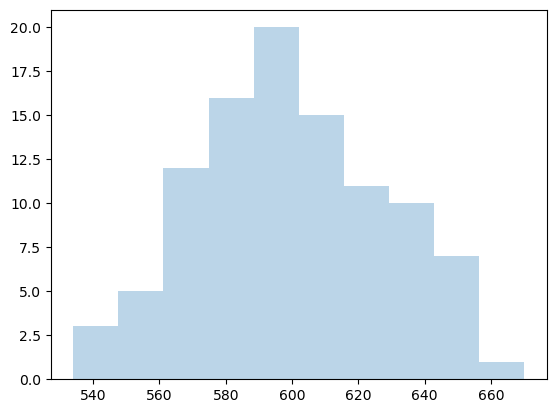

In [15]:
d_lens_dirichlet = [len(d) for d in each_worker_data]
# plt.hist(d_lens)
plt.hist(d_lens_dirichlet, alpha=.3)

## Evaluate FLD using the trim attack in the paper

In [34]:
'''
FAST BASELINE
'''
n_malicious = [5, 10, 15, 20, 25]

for n_mal in n_malicious:
    torch.cuda.empty_cache()
    # FLD initializations
    weight_record = []
    grad_record = []
    old_grad_list = []
    malicious_scores = np.zeros((1, num_workers))
    start_detection_epoch = 5
    window_size = 5
    assert (start_detection_epoch - window_size >= 0), 'start_detection_epoch %d should be more than window_size %d' % (start_detection_epoch, window_size)

    good_distance_rage = np.zeros((1, nbyz))
    best_val_acc = 0.0

    # Attack initializations
    attack_type = 'full_trim'
    dev_type = 'unit_vec'
    nbyz = n_mal ################### Changing variable ###################

    # FL training initializations
    num_workers = 100
    use_cuda = True
    criterion = nn.CrossEntropyLoss()
    local_lr=0.01
    local_batch_size=32
    local_epochs=2
    global_lr=1

    # FL model initializations
    def init_weights(m):
        if isinstance(m, nn.Linear):
            torch.nn.init.xavier_uniform_(m.weight)
            m.bias.data.fill_(0.01)
    fed_model = cnn().to(device)
    fed_model.apply(init_weights)
    model_received = []
    for i, (name, param) in enumerate(fed_model.state_dict().items()):
        model_received = param.view(-1).data.type(torch.cuda.FloatTensor) if len(model_received) == 0 else torch.cat((model_received, param.view(-1).data.type(torch.cuda.FloatTensor)))

    for e in range(50):
        user_grads=[]
        round_clients = np.arange(num_workers)
        round_benign = round_clients
        user_grads=[]

        for i in round_benign:
            model = copy.deepcopy(fed_model)
            optimizer = optim.SGD(model.parameters(), lr = lr, momentum=0.9, weight_decay=1e-4)

            for epoch in range(local_epochs):
                train_loss, train_acc = train(
                    each_worker_data[i].reshape(-1, 1, 28, 28),
                    torch.Tensor(each_worker_label[i]).long(), model, optimizer, local_batch_size)

            params = []
            for i, (name, param) in enumerate(model.state_dict().items()):
                params = param.view(-1).data.type(torch.cuda.FloatTensor) if len(params) == 0 else torch.cat(
                    (params, param.view(-1).data.type(torch.cuda.FloatTensor)))

            update =  (params - model_received)
            user_grads = update[None,:] if len(user_grads) == 0 else torch.cat((user_grads, update[None,:]), 0)

        weight = model_received

        if (e > start_detection_epoch):
            hvp = lbfgs(weight_record, grad_record, weight - last_weight)
            hvp = np.squeeze(hvp)
        else:
            hvp = None

        good_current_grads = copy.deepcopy(user_grads[:nbyz])
        if hvp is not None:
            pred_grad = copy.deepcopy(good_old_grads)
            distance = []
            for i in range(len(good_old_grads)):
                pred_grad[i] += torch.from_numpy(hvp).to(device)
            good_distance_rage = np.concatenate(
                (good_distance_rage, torch.norm(pred_grad - good_current_grads, dim = 1).cpu().numpy()[None,:]), 0)

        if attack_type != 'none' and (e < start_detection_epoch):
            user_grads = full_trim(user_grads, nbyz)
            # user_grads[:nbyz] = full_trim(user_grads[:nbyz], nbyz)
        elif e > start_detection_epoch:
            if attack_type == 'full_trim':
                user_grads = full_trim(user_grads, nbyz)
            elif attack_type == 'none':
                pass
            else:
                if attack_type == 'LIE':
                    print("LIE")
                    z = 0.1
                    noise_avg = torch.mean(user_grads[:nbyz], dim=0)
                    noise_std = torch.std(user_grads[:nbyz], dim=0)
                    noise = noise_avg + z * noise_std
                elif attack_type == 'NDSS21':
                    distance_bound = np.random.choice(np.mean(good_distance_rage[-1:], 0))
                    model_re = torch.mean(good_current_grads, dim=0)
                    if dev_type == 'unit_vec':
                        deviation = model_re / torch.norm(model_re)  # unit vector, dir opp to good dir
                    elif dev_type == 'sign':
                        deviation = torch.sign(model_re)
                    elif dev_type == 'std':
                        deviation = torch.std(good_current_grads, 0)
                    # noise = deviation * ((distance_bound + np.random.uniform(0, np.std(good_distance_rage[-1]))) / torch.norm(deviation))
                    noise = deviation * ((distance_bound)) / torch.norm(deviation)
                elif attack_type == 'mod_trim':
                    mal_grads= full_trim(user_grads[:nbyz], nbyz)
                    pass
                else:
                    noise = torch.zeros(hvp.shape).to(device)
                for m in range(nbyz):
                    user_grads[m] = old_grad_list[m] + torch.from_numpy(hvp).to(device) + noise

        agg_grads, distance = trimmed_mean(old_grad_list, user_grads, nbyz, hvp)

        if distance is not None and e > (start_detection_epoch - window_size):
            malicious_scores = np.concatenate((malicious_scores, distance[None, :]), 0)

        if malicious_scores.shape[0] >= window_size+1:
            if detection1(np.sum(malicious_scores[-window_size:], axis=0), nbyz):
                print('Stop at iteration:', e)
                detection(np.sum(malicious_scores[-window_size:], axis=0), nbyz, num_workers)
                break

        if e > (start_detection_epoch - window_size):
            weight_record.append(weight - last_weight)
            grad_record.append(agg_grads - last_grad)

        if (len(weight_record) > window_size):
            del weight_record[0]
            del grad_record[0]

        last_weight = weight
        last_grad = agg_grads
        old_grad_list = user_grads
        good_old_grads = good_current_grads

        del user_grads
        model_received = model_received + global_lr * agg_grads
        fed_model = cnn().to(device)
        fed_model.apply(init_weights)
        start_idx=0
        state_dict = {}
        previous_name = 'none'
        for i, (name, param) in enumerate(fed_model.state_dict().items()):
            start_idx = 0 if i == 0 else start_idx + len(fed_model.state_dict()[previous_name].data.view(-1))
            start_end = start_idx + len(fed_model.state_dict()[name].data.view(-1))
            params = model_received[start_idx:start_end].reshape(fed_model.state_dict()[name].data.shape)
            state_dict[name] = params
            previous_name = name

        fed_model.load_state_dict(state_dict)
        val_loss, val_acc = test(global_test_data.reshape(-1,1,28,28), global_test_label.long(), fed_model, criterion, use_cuda, batch_size=50)
        is_best = best_val_acc < val_acc
        best_val_acc = max(best_val_acc, val_acc)
        if e%5==0 or e==99:
            print('e %d | val_loss %.3f val acc %.3f | best val_acc %.3f' % (e, val_loss, val_acc, best_val_acc))

e 0 | val_loss 2.068 val acc 47.287 | best val_acc 47.287
e 5 | val_loss 0.255 val acc 92.753 | best val_acc 92.753
Attack Detected!
Stop at iteration: 10
acc 0.9900; recall 1.0000; fpr 0.0125; fnr 0.0000;
0.949640709729089


## Adaptive attack on FLD-trmean + Fang-0.5 distribution + m = {5, 10, 15, 20, 25}%

In [26]:
'''
SLOW BASELINE
'''
# delete all FLD variables
del weight_record, grad_record, old_grad_list, num_workers, malicious_scores

torch.cuda.empty_cache()
weight_record = []
grad_record = []
old_grad_list = []

num_workers = 100
malicious_scores = np.zeros((1, num_workers))

attack_type = 'NDSS21'
dev_type = 'unit_vec'
use_cuda = True
criterion = nn.CrossEntropyLoss()

def init_weights(m):
    if isinstance(m, nn.Linear):
        torch.nn.init.xavier_uniform_(m.weight)
        m.bias.data.fill_(0.01)
net = cnn().to(device)
net.apply(init_weights)

lr = 0.005
start_detection_epoch = 10
window_size = 10
assert (start_detection_epoch - window_size >= 0), 'start_detection_epoch %d should be more than window_size %d' % (start_detection_epoch, window_size)
nbyz = 20
good_distance_rage = np.zeros((1, nbyz))
best_val_acc = 0.0

for e in range(1000):
    cnn_optimizer = SGD(net.parameters(), lr = lr)
    user_grads = []

    for i in range(num_workers):
        net_ = copy.deepcopy(net)
        net_.zero_grad()
        output = net_(each_worker_data[i].reshape(-1, 1, 28, 28).cuda())
        loss = criterion(output, each_worker_label[i].long().cuda())
        
        loss.backward(retain_graph = True)
        param_grad=[]
        for param in net_.parameters():
            param_grad=param.grad.data.view(-1) if not len(param_grad) else torch.cat((param_grad,param.grad.view(-1)))
        user_grads=param_grad[None, :] if len(user_grads)==0 else torch.cat((user_grads,param_grad[None,:]), 0)
    
    tmp = []
    for param in net.parameters():
        tmp = param.data.view(-1) if not len(tmp) else torch.cat((tmp, param.data.view(-1)))
    weight = tmp

    if (e > start_detection_epoch):
        hvp = lbfgs(weight_record, grad_record, weight - last_weight)
        hvp = np.squeeze(hvp)
    else:
        hvp = None

    good_current_grads = copy.deepcopy(user_grads[:nbyz])
    if hvp is not None:
        pred_grad = copy.deepcopy(good_old_grads)
        distance = []
        for i in range(len(good_old_grads)):
            pred_grad[i] += torch.from_numpy(hvp).to(device)
        good_distance_rage = np.concatenate(
            (good_distance_rage, torch.norm(pred_grad - good_current_grads, dim = 1).cpu().numpy()[None,:]), 0)
        
    if attack_type != 'none' and (e < start_detection_epoch):
        user_grads = full_trim(user_grads, nbyz)
    elif e > start_detection_epoch:
        if attack_type == 'full_trim':
            user_grads = full_trim(user_grads, nbyz)
        elif attack_type == 'none':
            pass
        else:
            if attack_type == 'LIE':
                print("LIE")
                z = 0.1
                noise_avg = torch.mean(user_grads[:nbyz], dim=0)
                noise_std = torch.std(user_grads[:nbyz], dim=0)
                noise = noise_avg + z * noise_std
            elif attack_type == 'NDSS21':
                distance_bound = np.random.choice(np.mean(good_distance_rage[-1:], 0))
                model_re = torch.mean(good_current_grads, dim=0)
                if dev_type == 'unit_vec':
                    deviation = model_re / torch.norm(model_re)  # unit vector, dir opp to good dir
                elif dev_type == 'sign':
                    deviation = torch.sign(model_re)
                elif dev_type == 'std':
                    deviation = torch.std(good_current_grads, 0)
                # noise = deviation * ((distance_bound + np.random.uniform(0, np.std(good_distance_rage[-1]))) / torch.norm(deviation))
                noise = deviation * ((distance_bound)) / torch.norm(deviation)
            elif attack_type == 'mod_trim':
                mal_grads= full_trim(user_grads[:nbyz], nbyz)
                pass
            else:
                noise = torch.zeros(hvp.shape).to(device)
            for m in range(nbyz):
                user_grads[m] = old_grad_list[m] + torch.from_numpy(hvp).to(device) + noise

    agg_grads, distance = trimmed_mean(old_grad_list, user_grads, nbyz, hvp)
    
    if distance is not None and e > (start_detection_epoch - window_size):
        malicious_scores = np.concatenate((malicious_scores, distance[None, :]), 0)

    if malicious_scores.shape[0] >= window_size+1:
        if detection1(np.sum(malicious_scores[-window_size:], axis=0), nbyz):
            print('Stop at iteration:', e)
            detection(np.sum(malicious_scores[-window_size:], axis=0), nbyz, num_workers)
            break

    if e > (start_detection_epoch - window_size):
        weight_record.append(weight - last_weight)
        grad_record.append(agg_grads - last_grad)
    
    if (len(weight_record) > window_size):
        del weight_record[0]
        del grad_record[0]
    
    last_weight = weight
    last_grad = agg_grads
    old_grad_list = user_grads
    good_old_grads = good_current_grads

    del user_grads
    start_idx=0
    cnn_optimizer.zero_grad()
    model_grads=[]
    for i, param in enumerate(net.parameters()):
        param_=agg_grads[start_idx:start_idx+len(param.data.view(-1))].reshape(param.data.shape)
        start_idx=start_idx+len(param.data.view(-1))
        param_=param_.cuda()
        model_grads.append(param_)

    cnn_optimizer.step(model_grads)
    val_loss, val_acc = test(global_test_data.reshape(-1,1,28,28), global_test_label.long(), net, criterion, use_cuda, batch_size=50)
    is_best = best_val_acc < val_acc
    best_val_acc = max(best_val_acc, val_acc)
    if e%5==0 or e==999:
        print('e %d | val_loss %.3f val acc %.3f | best val_acc %.3f' % (e, val_loss, val_acc, best_val_acc))

e 0 | val_loss 2.308 val acc 6.919 | best val_acc 6.919
e 5 | val_loss 2.310 val acc 6.680 | best val_acc 6.919
e 10 | val_loss 2.310 val acc 6.760 | best val_acc 6.919
e 15 | val_loss 2.303 val acc 7.556 | best val_acc 7.556
e 20 | val_loss 2.297 val acc 8.462 | best val_acc 8.462
e 25 | val_loss 2.290 val acc 9.796 | best val_acc 9.796
e 30 | val_loss 2.284 val acc 11.299 | best val_acc 11.299
e 35 | val_loss 2.278 val acc 12.683 | best val_acc 12.683
e 40 | val_loss 2.272 val acc 13.907 | best val_acc 13.907
e 45 | val_loss 2.265 val acc 15.689 | best val_acc 15.689
e 50 | val_loss 2.259 val acc 17.133 | best val_acc 17.133
e 55 | val_loss 2.253 val acc 18.128 | best val_acc 18.128
e 60 | val_loss 2.247 val acc 19.124 | best val_acc 19.124
e 65 | val_loss 2.240 val acc 19.960 | best val_acc 19.960
e 70 | val_loss 2.234 val acc 21.523 | best val_acc 21.523
e 75 | val_loss 2.227 val acc 23.654 | best val_acc 23.654
e 80 | val_loss 2.220 val acc 25.963 | best val_acc 25.963
e 85 | val_

# Slow baseline results

## NDSS21 + sign
### run 1
Attack Detected!
Stop at iteration: 113
acc 0.6500; recall 0.0000; fpr 0.3158; fnr 1.0000;
0.7177836650168169

Attack Detected!
Stop at iteration: 125
acc 0.6200; recall 0.0000; fpr 0.3111; fnr 1.0000;
0.7041198588150981

Attack Detected!
Stop at iteration: 152
acc 0.4800; recall 0.0000; fpr 0.4353; fnr 1.0000;
0.6699105149889638

Attack Detected!
Stop at iteration: 26
acc 0.2900; recall 0.0000; fpr 0.6375; fnr 1.0000;
0.6881105605642764

Attack Detected!
Stop at iteration: 43
acc 0.6600; recall 1.0000; fpr 0.4533; fnr 0.0000;
0.6907586272058862

### run 2

Attack Detected!
Stop at iteration: 97
acc 0.5500; recall 0.0000; fpr 0.4211; fnr 1.0000;
0.6683849381079955

Attack Detected!
Stop at iteration: 20
acc 0.7100; recall 1.0000; fpr 0.3222; fnr 0.0000;
0.7064875030402401

Attack Detected!
Stop at iteration: 21
acc 0.6400; recall 1.0000; fpr 0.4235; fnr 0.0000;
0.6721461157406335

Attack Detected!
Stop at iteration: 101
acc 0.2800; recall 0.0000; fpr 0.6500; fnr 1.0000;
0.6459235493686176

Attack Detected!
Stop at iteration: 26
acc 0.8100; recall 1.0000; fpr 0.2533; fnr 0.0000;
0.7027147928146711

### run 3
Attack Detected!
Stop at iteration: 97
acc 0.5500; recall 0.0000; fpr 0.4211; fnr 1.0000;
0.6683849381079955

Attack Detected!
Stop at iteration: 20
acc 0.7100; recall 1.0000; fpr 0.3222; fnr 0.0000;
0.7064875030402401

Attack Detected!
Stop at iteration: 21
acc 0.6400; recall 1.0000; fpr 0.4235; fnr 0.0000;
0.6721461157406335

Attack Detected!
Stop at iteration: 101
acc 0.2800; recall 0.0000; fpr 0.6500; fnr 1.0000;
0.6459235493686176

Attack Detected!
Stop at iteration: 26
acc 0.8100; recall 1.0000; fpr 0.2533; fnr 0.0000;
0.7027147928146711


### run 4*
* (distance_bound = np.mean(good_distances))

Attack Detected!
Stop at iteration: 109
acc 0.5300; recall 0.0000; fpr 0.4421; fnr 1.0000;

Attack Detected!
Stop at iteration: 105
acc 0.4800; recall 0.0000; fpr 0.4667; fnr 1.0000;

Attack Detected!
Stop at iteration: 128
acc 0.5100; recall 0.0000; fpr 0.4000; fnr 1.0000;


Attack Detected!
Stop at iteration: 120
acc 0.5000; recall 0.0000; fpr 0.3750; fnr 1.0000;

Attack Detected!
Stop at iteration: 34
acc 0.5300; recall 0.0000; fpr 0.2933; fnr 1.0000;

### run 5*
Attack Detected!
Stop at iteration: 129
acc 0.5500; recall 0.0000; fpr 0.4211; fnr 1.0000;

Attack Detected!
Stop at iteration: 125
acc 0.5400; recall 0.0000; fpr 0.4000; fnr 1.0000;

Attack Detected!
Stop at iteration: 132
acc 0.5500; recall 0.0000; fpr 0.3529; fnr 1.0000;

Attack Detected!
Stop at iteration: 52
acc 0.3700; recall 0.0000; fpr 0.5375; fnr 1.0000;

Attack Detected!
Stop at iteration: 107
acc 0.1500; recall 0.0000; fpr 0.8000; fnr 1.0000;

### run 6*
Attack Detected!
Stop at iteration: 124
acc 0.5500; recall 0.0000; fpr 0.3889; fnr 1.0000;

Attack Detected!
Stop at iteration: 122
acc 0.0500; recall 0.0000; fpr 0.9412; fnr 1.0000;

Attack Detected!
Stop at iteration: 30
acc 0.5300; recall 0.0000; fpr 0.3375; fnr 1.0000;

Attack Detected!
Stop at iteration: 20
acc 0.9300; recall 1.0000; fpr 0.0933; fnr 0.0000;

## NDSS21 + unit_vec
### run 1
Attack Detected!
Stop at iteration: 119
acc 0.2500; recall 0.0000; fpr 0.7368; fnr 1.0000;
0.6906284998384221

Attack Detected!
Stop at iteration: 47
acc 0.7200; recall 1.0000; fpr 0.3111; fnr 0.0000;
0.6657499192267171

Attack Detected!
Stop at iteration: 20
acc 0.9900; recall 1.0000; fpr 0.0118; fnr 0.0000;
0.7902476191649904

Attack Detected!
Stop at iteration: 45
acc 0.4900; recall 0.0000; fpr 0.3875; fnr 1.0000;
0.6903751972083814

Attack Detected!
Stop at iteration: 80
acc 0.0100; recall 0.0000; fpr 0.9867; fnr 1.0000;
0.7476418065819977

### run 2
Attack Detected!
Stop at iteration: 105
acc 0.6300; recall 0.0000; fpr 0.3368; fnr 1.0000;
0.6776102750332995

Attack Detected!
Stop at iteration: 88
acc 0.1100; recall 0.0000; fpr 0.8778; fnr 1.0000;
0.7312029089370341

Attack Detected!
Stop at iteration: 21
acc 0.6700; recall 1.0000; fpr 0.3882; fnr 0.0000;
0.6671735632726175

Attack Detected!
Stop at iteration: 38
acc 0.4900; recall 0.0000; fpr 0.3875; fnr 1.0000;
0.6915442086050451

Attack Detected!
Stop at iteration: 50
acc 0.4100; recall 0.0000; fpr 0.4533; fnr 1.0000;
0.6857216699946427

### run 3

In [17]:
'''
SLOW BASELINE
'''
n_malicious = [5, 10, 15, 20, 25]

for n_mal in n_malicious:
    
    torch.cuda.empty_cache()
#     # delete all variables
#     del weight_record, grad_record, old_grad_list, num_workers, malicious_scores, start_detection_epoch, window_size
#     del good_distance_rage
#     del nepochs, num_workers, local_lr, local_epochs, global_lr, agr
#     del attack_type, dev_type, fed_model

    # FL training initializations
    nepochs=1000
    num_workers = 100
    use_cuda = True
    criterion = nn.CrossEntropyLoss()
    local_lr=1
    global_lr=0.01
    agr='tr_mean' # ['average', 'median', 'tr_mean']

    # Attack initializations
    attack_type = 'NDSS21'
    dev_type = 'sign'
    nbyz = n_mal ################### Changing variable ###################

    # FLD initializations
    weight_record = []
    grad_record = []
    old_grad_list = []
    malicious_scores = np.zeros((1, num_workers))
    start_detection_epoch = 10
    window_size = 10
    assert (start_detection_epoch - window_size >= 0), 'start_detection_epoch %d should be more than window_size %d' % (start_detection_epoch, window_size)
    good_distance_rage = np.zeros((1, nbyz))
    best_val_acc = 0.0

    # FL model initializations
    def init_weights(m):
        if isinstance(m, nn.Linear):
            torch.nn.init.xavier_uniform_(m.weight)
            m.bias.data.fill_(0.01)
    fed_model = cnn().to(device)
    fed_model.apply(init_weights)
    
    for e in range(nepochs):
        cnn_optimizer = SGD(fed_model.parameters(), lr = global_lr)
        user_grads=[]
        round_clients = np.arange(num_workers)
        round_benign = round_clients
        for i in range(num_workers):
            net_ = copy.deepcopy(fed_model)
            net_.zero_grad()
            output = net_(each_worker_data[i].reshape(-1, 1, 28, 28).cuda())
            loss = criterion(output, each_worker_label[i].long().cuda())
            loss.backward(retain_graph = True)
            param_grad=[]
            for param in net_.parameters():
                param_grad=param.grad.data.view(-1) if not len(param_grad) else torch.cat((param_grad,param.grad.view(-1)))
            user_grads=param_grad[None, :] if len(user_grads)==0 else torch.cat((user_grads,param_grad[None,:]), 0)
            del net_

        weight = []
        for param in fed_model.parameters():
            weight = param.data.view(-1) if not len(weight) else torch.cat((weight, param.data.view(-1)))

        if (e > start_detection_epoch):
            hvp = lbfgs(weight_record, grad_record, weight - last_weight)
            hvp = np.squeeze(hvp)
        else:
            hvp = None

        good_current_grads = copy.deepcopy(user_grads[:nbyz])
        if hvp is not None:
            pred_grad = copy.deepcopy(good_old_grads)
            distance = []
            for i in range(len(good_old_grads)):
                pred_grad[i] += torch.from_numpy(hvp).to(device)
            good_distance_rage = np.concatenate(
                (good_distance_rage, torch.norm(pred_grad - good_current_grads, dim = 1).cpu().numpy()[None,:]), 0)

        if attack_type != 'none' and (e < start_detection_epoch):
            user_grads = full_trim(user_grads, nbyz)
            # user_grads[:nbyz] = full_trim(user_grads[:nbyz], nbyz)
        elif e > start_detection_epoch:
            if attack_type == 'full_trim':
                user_grads = full_trim(user_grads, nbyz)
            elif attack_type == 'none':
                pass
            else:
                if attack_type == 'NDSS21':
                    model_re = torch.mean(good_current_grads, dim=0)
                    if dev_type == 'unit_vec':
                        deviation = model_re / torch.norm(model_re)  # unit vector, dir opp to good dir
                    elif dev_type == 'sign':
                        deviation = torch.sign(model_re)
                    elif dev_type == 'std':
                        deviation = torch.std(good_current_grads, 0)
                    # noise = deviation * ((distance_bound + np.random.uniform(0, np.std(good_distance_rage[-1]))) / torch.norm(deviation))
                    
                else:
                    noise = torch.zeros(hvp.shape).to(device)
                for m in range(nbyz):
                    distance_bound = np.mean(np.mean(good_distance_rage[-1:], 0))
                    noise = deviation * ((distance_bound)) / torch.norm(deviation)
                    user_grads[m] = old_grad_list[m] + torch.from_numpy(hvp).to(device) + noise

        agg_grads, distance = fldetector(old_grad_list, user_grads, nbyz, hvp, agr=agr)

        if distance is not None and e > (start_detection_epoch - window_size):
            malicious_scores = np.concatenate((malicious_scores, distance[None, :]), 0)

        if malicious_scores.shape[0] >= window_size+1:
            if e == window_size + 1: print('shape of malicious scores: ', malicious_scores.shape)
            if detection1(np.sum(malicious_scores[-window_size:], axis=0), nbyz):
                print('Stop at iteration:', e)
                detection(np.sum(malicious_scores[-window_size:], axis=0), nbyz, num_workers)
                break

        if e > (start_detection_epoch - window_size):
            weight_record.append(weight - last_weight)
            grad_record.append(agg_grads - last_grad)

        if (len(weight_record) > window_size):
            del weight_record[0]
            del grad_record[0]

        last_weight = weight
        last_grad = agg_grads
        old_grad_list = user_grads
        good_old_grads = good_current_grads

        del user_grads
        start_idx=0
        cnn_optimizer.zero_grad()
        model_grads=[]
        for i, param in enumerate(fed_model.parameters()):
            param_=agg_grads[start_idx:start_idx+len(param.data.view(-1))].reshape(param.data.shape)
            start_idx=start_idx+len(param.data.view(-1))
            param_=param_.cuda()
            model_grads.append(param_)
        cnn_optimizer.step(model_grads)
        val_loss, val_acc = test(global_test_data.reshape(-1,1,28,28), global_test_label.long(), fed_model, criterion, use_cuda, batch_size=50)
        is_best = best_val_acc < val_acc
        best_val_acc = max(best_val_acc, val_acc)
        if e%20==0 or e==nepochs-1:
            print('e %d | val_loss %.3f val acc %.3f | best val_acc %.3f' % (e, val_loss, val_acc, best_val_acc))

e 0 | val_loss 2.317 val acc 9.613 | best val_acc 9.613
e 20 | val_loss 2.234 val acc 29.784 | best val_acc 29.784
e 40 | val_loss 2.144 val acc 49.726 | best val_acc 49.726
e 60 | val_loss 2.010 val acc 69.110 | best val_acc 69.110
e 80 | val_loss 1.795 val acc 74.669 | best val_acc 74.669
e 100 | val_loss 1.475 val acc 77.368 | best val_acc 77.368
Attack Detected!
Stop at iteration: 109
acc 0.5300; recall 0.0000; fpr 0.4421; fnr 1.0000;
0.6457644764619055
e 0 | val_loss 2.306 val acc 12.780 | best val_acc 12.780
e 20 | val_loss 2.240 val acc 26.138 | best val_acc 26.138
e 40 | val_loss 2.135 val acc 45.333 | best val_acc 45.333
e 60 | val_loss 1.971 val acc 65.136 | best val_acc 65.136
e 80 | val_loss 1.726 val acc 70.495 | best val_acc 70.495
e 100 | val_loss 1.400 val acc 74.968 | best val_acc 74.968
Attack Detected!
Stop at iteration: 105
acc 0.4800; recall 0.0000; fpr 0.4667; fnr 1.0000;
0.6327764486758649
e 0 | val_loss 2.333 val acc 9.712 | best val_acc 9.712
e 20 | val_loss 2.

In [18]:
'''
SLOW BASELINE
'''
n_malicious = [5, 10, 15, 20, 25]

for n_mal in n_malicious:
    
    torch.cuda.empty_cache()
#     # delete all variables
#     del weight_record, grad_record, old_grad_list, num_workers, malicious_scores, start_detection_epoch, window_size
#     del good_distance_rage
#     del nepochs, num_workers, local_lr, local_epochs, global_lr, agr
#     del attack_type, dev_type, fed_model

    # FL training initializations
    nepochs=1000
    num_workers = 100
    use_cuda = True
    criterion = nn.CrossEntropyLoss()
    local_lr=1
    global_lr=0.01
    agr='tr_mean' # ['average', 'median', 'tr_mean']

    # Attack initializations
    attack_type = 'NDSS21'
    dev_type = 'sign'
    nbyz = n_mal ################### Changing variable ###################

    # FLD initializations
    weight_record = []
    grad_record = []
    old_grad_list = []
    malicious_scores = np.zeros((1, num_workers))
    start_detection_epoch = 10
    window_size = 10
    assert (start_detection_epoch - window_size >= 0), 'start_detection_epoch %d should be more than window_size %d' % (start_detection_epoch, window_size)
    good_distance_rage = np.zeros((1, nbyz))
    best_val_acc = 0.0

    # FL model initializations
    def init_weights(m):
        if isinstance(m, nn.Linear):
            torch.nn.init.xavier_uniform_(m.weight)
            m.bias.data.fill_(0.01)
    fed_model = cnn().to(device)
    fed_model.apply(init_weights)
    
    for e in range(nepochs):
        cnn_optimizer = SGD(fed_model.parameters(), lr = global_lr)
        user_grads=[]
        round_clients = np.arange(num_workers)
        round_benign = round_clients
        for i in range(num_workers):
            net_ = copy.deepcopy(fed_model)
            net_.zero_grad()
            output = net_(each_worker_data[i].reshape(-1, 1, 28, 28).cuda())
            loss = criterion(output, each_worker_label[i].long().cuda())
            loss.backward(retain_graph = True)
            param_grad=[]
            for param in net_.parameters():
                param_grad=param.grad.data.view(-1) if not len(param_grad) else torch.cat((param_grad,param.grad.view(-1)))
            user_grads=param_grad[None, :] if len(user_grads)==0 else torch.cat((user_grads,param_grad[None,:]), 0)
            del net_

        weight = []
        for param in fed_model.parameters():
            weight = param.data.view(-1) if not len(weight) else torch.cat((weight, param.data.view(-1)))

        if (e > start_detection_epoch):
            hvp = lbfgs(weight_record, grad_record, weight - last_weight)
            hvp = np.squeeze(hvp)
        else:
            hvp = None

        good_current_grads = copy.deepcopy(user_grads[:nbyz])
        if hvp is not None:
            pred_grad = copy.deepcopy(good_old_grads)
            distance = []
            for i in range(len(good_old_grads)):
                pred_grad[i] += torch.from_numpy(hvp).to(device)
            good_distance_rage = np.concatenate(
                (good_distance_rage, torch.norm(pred_grad - good_current_grads, dim = 1).cpu().numpy()[None,:]), 0)

        if attack_type != 'none' and (e < start_detection_epoch):
            user_grads = full_trim(user_grads, nbyz)
            # user_grads[:nbyz] = full_trim(user_grads[:nbyz], nbyz)
        elif e > start_detection_epoch:
            if attack_type == 'full_trim':
                user_grads = full_trim(user_grads, nbyz)
            elif attack_type == 'none':
                pass
            else:
                if attack_type == 'NDSS21':
                    model_re = torch.mean(good_current_grads, dim=0)
                    if dev_type == 'unit_vec':
                        deviation = model_re / torch.norm(model_re)  # unit vector, dir opp to good dir
                    elif dev_type == 'sign':
                        deviation = torch.sign(model_re)
                    elif dev_type == 'std':
                        deviation = torch.std(good_current_grads, 0)
                    # noise = deviation * ((distance_bound + np.random.uniform(0, np.std(good_distance_rage[-1]))) / torch.norm(deviation))
                    
                else:
                    noise = torch.zeros(hvp.shape).to(device)
                for m in range(nbyz):
                    distance_bound = np.mean(np.mean(good_distance_rage[-1:], 0))
                    noise = deviation * ((distance_bound)) / torch.norm(deviation)
                    user_grads[m] = old_grad_list[m] + torch.from_numpy(hvp).to(device) + noise

        agg_grads, distance = fldetector(old_grad_list, user_grads, nbyz, hvp, agr=agr)

        if distance is not None and e > (start_detection_epoch - window_size):
            malicious_scores = np.concatenate((malicious_scores, distance[None, :]), 0)

        if malicious_scores.shape[0] >= window_size+1:
            if e == window_size + 1: print('shape of malicious scores: ', malicious_scores.shape)
            if detection1(np.sum(malicious_scores[-window_size:], axis=0), nbyz):
                print('Stop at iteration:', e)
                detection(np.sum(malicious_scores[-window_size:], axis=0), nbyz, num_workers)
                break

        if e > (start_detection_epoch - window_size):
            weight_record.append(weight - last_weight)
            grad_record.append(agg_grads - last_grad)

        if (len(weight_record) > window_size):
            del weight_record[0]
            del grad_record[0]

        last_weight = weight
        last_grad = agg_grads
        old_grad_list = user_grads
        good_old_grads = good_current_grads

        del user_grads
        start_idx=0
        cnn_optimizer.zero_grad()
        model_grads=[]
        for i, param in enumerate(fed_model.parameters()):
            param_=agg_grads[start_idx:start_idx+len(param.data.view(-1))].reshape(param.data.shape)
            start_idx=start_idx+len(param.data.view(-1))
            param_=param_.cuda()
            model_grads.append(param_)
        cnn_optimizer.step(model_grads)
        val_loss, val_acc = test(global_test_data.reshape(-1,1,28,28), global_test_label.long(), fed_model, criterion, use_cuda, batch_size=50)
        is_best = best_val_acc < val_acc
        best_val_acc = max(best_val_acc, val_acc)
        if e%20==0 or e==nepochs-1:
            print('e %d | val_loss %.3f val acc %.3f | best val_acc %.3f' % (e, val_loss, val_acc, best_val_acc))

e 0 | val_loss 2.320 val acc 10.001 | best val_acc 10.001
e 20 | val_loss 2.252 val acc 10.539 | best val_acc 10.539
e 40 | val_loss 2.183 val acc 31.995 | best val_acc 31.995
e 60 | val_loss 2.085 val acc 60.922 | best val_acc 60.922
e 80 | val_loss 1.932 val acc 72.348 | best val_acc 72.348
e 100 | val_loss 1.692 val acc 76.372 | best val_acc 76.372
e 120 | val_loss 1.364 val acc 79.161 | best val_acc 79.161
Attack Detected!
Stop at iteration: 129
acc 0.5500; recall 0.0000; fpr 0.4211; fnr 1.0000;
0.6694340981362383
e 0 | val_loss 2.315 val acc 5.907 | best val_acc 5.907
e 20 | val_loss 2.248 val acc 17.681 | best val_acc 17.681
e 40 | val_loss 2.163 val acc 46.060 | best val_acc 46.060
e 60 | val_loss 2.054 val acc 63.323 | best val_acc 63.323
e 80 | val_loss 1.893 val acc 70.674 | best val_acc 70.674
e 100 | val_loss 1.655 val acc 74.410 | best val_acc 74.410
e 120 | val_loss 1.346 val acc 77.757 | best val_acc 77.757
Attack Detected!
Stop at iteration: 125
acc 0.5400; recall 0.000

In [24]:
'''
SLOW BASELINE
'''
n_malicious = [5, 10, 15, 20]
n_runs=5
results = {}
for n_mal in n_malicious:
    results[n_mal] = {'acc': [], 'fpr': [], 'fnr': [], 'auc': [], 'stop_e': []}
    for run in range(n_runs):
        torch.cuda.empty_cache()
        try:
            # delete all variables
            del weight_record, grad_record, old_grad_list, num_workers, malicious_scores, start_detection_epoch, window_size
            del good_distance_rage
            del nepochs, num_workers, local_lr, local_epochs, global_lr, agr
            del attack_type, dev_type, fed_model
        except:
            pass

        # FL training initializations
        nepochs=1000
        num_workers = 100
        use_cuda = True
        criterion = nn.CrossEntropyLoss()
        local_lr=1
        global_lr=0.01
        agr='tr_mean' # ['average', 'median', 'tr_mean']

        # Attack initializations
        attack_type = 'NDSS21'
        dev_type = 'sign'
        nbyz = n_mal

        # FLD initializations
        weight_record = []
        grad_record = []
        old_grad_list = []
        malicious_scores = np.zeros((1, num_workers-(20-nbyz)))
        start_detection_epoch = 10
        window_size = 10
        assert (start_detection_epoch - window_size >= 0), 'start_detection_epoch %d should be more than window_size %d' % (start_detection_epoch, window_size)
        good_distance_rage = np.zeros((1, nbyz))
        best_val_acc = 0.0

        # FL model initializations
        def init_weights(m):
            if isinstance(m, nn.Linear):
                torch.nn.init.xavier_uniform_(m.weight)
                m.bias.data.fill_(0.01)
        fed_model = cnn().to(device)
        fed_model.apply(init_weights)

        for e in range(nepochs):
            cnn_optimizer = SGD(fed_model.parameters(), lr = global_lr)
            user_grads=[]

            for i in range((20-nbyz), num_workers):
                net_ = copy.deepcopy(fed_model)
                net_.zero_grad()
                output = net_(each_worker_data[i].reshape(-1, 1, 28, 28).cuda())
                loss = criterion(output, each_worker_label[i].long().cuda())
                loss.backward(retain_graph = True)
                param_grad=[]
                for param in net_.parameters():
                    param_grad=param.grad.data.view(-1) if not len(param_grad) else torch.cat((param_grad,param.grad.view(-1)))
                user_grads=param_grad[None, :] if len(user_grads)==0 else torch.cat((user_grads,param_grad[None,:]), 0)
                del net_

            weight = []
            for param in fed_model.parameters():
                weight = param.data.view(-1) if not len(weight) else torch.cat((weight, param.data.view(-1)))

            if (e > start_detection_epoch):
                hvp = lbfgs(weight_record, grad_record, weight - last_weight)
                hvp = np.squeeze(hvp)
            else:
                hvp = None

            good_current_grads = copy.deepcopy(user_grads[:nbyz])
            if hvp is not None:
                pred_grad = copy.deepcopy(good_old_grads)
                distance = []
                for i in range(len(good_old_grads)):
                    pred_grad[i] += torch.from_numpy(hvp).to(device)
                good_distance_rage = np.concatenate(
                    (good_distance_rage, torch.norm(pred_grad - good_current_grads, dim = 1).cpu().numpy()[None,:]), 0)

            if attack_type != 'none' and (e < start_detection_epoch):
                user_grads = full_trim(user_grads, nbyz)
                # user_grads[:nbyz] = full_trim(user_grads[:nbyz], nbyz)
            elif e > start_detection_epoch:
                if attack_type == 'full_trim':
                    user_grads = full_trim(user_grads, nbyz)
                elif attack_type == 'none':
                    pass
                else:
                    if attack_type == 'NDSS21':
                        model_re = torch.mean(good_current_grads, dim=0)
                        if dev_type == 'unit_vec':
                            deviation = model_re / torch.norm(model_re)  # unit vector, dir opp to good dir
                        elif dev_type == 'sign':
                            deviation = torch.sign(model_re)
                        elif dev_type == 'std':
                            deviation = torch.std(good_current_grads, 0)
                        # noise = deviation * ((distance_bound + np.random.uniform(0, np.std(good_distance_rage[-1]))) / torch.norm(deviation))

                    else:
                        noise = torch.zeros(hvp.shape).to(device)
                    for m in range(nbyz):
                        distance_bound = np.mean(np.mean(good_distance_rage[-1:], 0))
                        noise = deviation * ((distance_bound)) / torch.norm(deviation)
                        user_grads[m] = old_grad_list[m] + torch.from_numpy(hvp).to(device) + noise

            agg_grads, distance = fldetector(old_grad_list, user_grads, nbyz, hvp, agr=agr)

            if distance is not None and e > (start_detection_epoch - window_size):
                malicious_scores = np.concatenate((malicious_scores, distance[None, :]), 0)

            if malicious_scores.shape[0] >= window_size+1:
                if e == window_size + 1: print('shape of malicious scores: ', malicious_scores.shape)
                if detection1(np.sum(malicious_scores[-window_size:], axis=0), nbyz):
                    print('Stop at iteration:', e)
                    print('run %d n_mal %d | val_loss %.3f val acc %.3f | best val_acc %.3f' % (run, n_mal, val_loss, val_acc, best_val_acc))
                    acc, fpr, fnr, auc = detection(
                        np.sum(malicious_scores[-window_size:], axis=0), nbyz, len(user_grads))
                    results[n_mal]['acc'].append(acc)
                    results[n_mal]['fpr'].append(fpr)
                    results[n_mal]['fnr'].append(fnr)
                    results[n_mal]['auc'].append(auc)
                    break

            if e > (start_detection_epoch - window_size):
                weight_record.append(weight - last_weight)
                grad_record.append(agg_grads - last_grad)

            if (len(weight_record) > window_size):
                del weight_record[0]
                del grad_record[0]

            last_weight = weight
            last_grad = agg_grads
            old_grad_list = user_grads
            good_old_grads = good_current_grads

            del user_grads
            start_idx=0
            cnn_optimizer.zero_grad()
            model_grads=[]
            for i, param in enumerate(fed_model.parameters()):
                param_=agg_grads[start_idx:start_idx+len(param.data.view(-1))].reshape(param.data.shape)
                start_idx=start_idx+len(param.data.view(-1))
                param_=param_.cuda()
                model_grads.append(param_)
            cnn_optimizer.step(model_grads)
            val_loss, val_acc = test(global_test_data.reshape(-1,1,28,28), global_test_label.long(), fed_model, criterion, use_cuda, batch_size=50)
            is_best = best_val_acc < val_acc
            best_val_acc = max(best_val_acc, val_acc)
        print('run %d e %d | val_loss %.3f val acc %.3f | best val_acc %.3f' % (run, e, val_loss, val_acc, best_val_acc))

Stop at iteration: 113
run 0 n_mal 5 | val_loss 1.253 val acc 81.034 | best val_acc 81.034
acc 0.5294; recall 0.0000; fpr 0.4375; fnr 1.0000; auc 0.2812
run 0 e 113 | val_loss 1.253 val acc 81.034 | best val_acc 81.034
Stop at iteration: 95
run 1 n_mal 5 | val_loss 1.275 val acc 78.424 | best val_acc 78.424
acc 0.4824; recall 0.0000; fpr 0.4875; fnr 1.0000; auc 0.2562
run 1 e 95 | val_loss 1.275 val acc 78.424 | best val_acc 78.424
Stop at iteration: 128
run 2 n_mal 5 | val_loss 1.168 val acc 81.970 | best val_acc 81.970
acc 0.5529; recall 0.0000; fpr 0.4125; fnr 1.0000; auc 0.2938
run 2 e 128 | val_loss 1.168 val acc 81.970 | best val_acc 81.970
Stop at iteration: 89
run 3 n_mal 5 | val_loss 1.595 val acc 75.804 | best val_acc 75.804
acc 0.4824; recall 0.0000; fpr 0.4875; fnr 1.0000; auc 0.2562
run 3 e 89 | val_loss 1.595 val acc 75.804 | best val_acc 75.804
Stop at iteration: 91
run 4 n_mal 5 | val_loss 1.277 val acc 78.813 | best val_acc 78.813
acc 0.3882; recall 0.0000; fpr 0.5875;

In [26]:
for nmal in [5, 10, 15, 20]:
    print('nmal %d | fpr %f fnr %f auc %f' % (nmal,
                                              np.array(results[nmal]['fpr']).mean(),
                                              np.array(results[nmal]['fnr']).mean(),
                                              np.array(results[nmal]['auc']).mean(),
                                             ))

nmal 5 | fpr 0.482500 fnr 1.000000 auc 0.258750
nmal 10 | fpr 0.397500 fnr 1.000000 auc 0.301250
nmal 15 | fpr 0.480000 fnr 0.800000 auc 0.360000
nmal 20 | fpr 0.450000 fnr 1.000000 auc 0.275000


# Fast baseline results

In [17]:
'''
FAST BASELINE
'''
n_malicious = [5, 10, 15, 20, 25]

for n_mal in n_malicious:
    torch.cuda.empty_cache()
    try:
        # delete all variables
        del weight_record, grad_record, old_grad_list, num_workers, malicious_scores, start_detection_epoch, window_size
        del good_distance_rage
        del nepochs, num_workers, local_lr, local_epochs, global_lr, agr
        del attack_type, dev_type, fed_model
    except:
        pass
    
    # FL training initializations
    num_workers = 100
    use_cuda = True
    criterion = nn.CrossEntropyLoss()
    local_lr=0.01
    local_batch_size=32
    local_epochs=2
    global_lr=1
    agr='tr_mean' # ['average', 'median', 'tr_mean']

    # Attack initializations
    attack_type = 'NDSS21'
    dev_type = 'unit_vec'
    nbyz = n_mal ################### Changing variable ###################

    # FLD initializations
    weight_record = []
    grad_record = []
    old_grad_list = []
    malicious_scores = np.zeros((1, num_workers))
    start_detection_epoch = 5
    window_size = 5
    assert (start_detection_epoch - window_size >= 0), 'start_detection_epoch %d should be more than window_size %d' % (start_detection_epoch, window_size)
    good_distance_rage = np.zeros((1, nbyz))
    best_val_acc = 0.0
    

    # FL model initializations
    def init_weights(m):
        if isinstance(m, nn.Linear):
            torch.nn.init.xavier_uniform_(m.weight)
            m.bias.data.fill_(0.01)
    fed_model = cnn().to(device)
    fed_model.apply(init_weights)
    model_received = []
    for i, (name, param) in enumerate(fed_model.state_dict().items()):
        model_received = param.view(-1).data.type(torch.cuda.FloatTensor) if len(model_received) == 0 else torch.cat((model_received, param.view(-1).data.type(torch.cuda.FloatTensor)))

    for e in range(50):
        user_grads=[]
        round_clients = np.arange(num_workers)
        round_benign = round_clients
        user_grads=[]

        for i in round_benign:
            model = copy.deepcopy(fed_model)
            optimizer = optim.SGD(model.parameters(), lr = local_lr, momentum=0.9, weight_decay=1e-4)
            for epoch in range(local_epochs):
                train_loss, train_acc = train(
                    each_worker_data[i].reshape(-1, 1, 28, 28),
                    torch.Tensor(each_worker_label[i]).long(), model, optimizer, local_batch_size)

            params = []
            for i, (name, param) in enumerate(model.state_dict().items()):
                params = param.view(-1).data.type(torch.cuda.FloatTensor) if len(params) == 0 else torch.cat(
                    (params, param.view(-1).data.type(torch.cuda.FloatTensor)))

            update =  (params - model_received)
            user_grads = update[None,:] if len(user_grads) == 0 else torch.cat((user_grads, update[None,:]), 0)

        weight = model_received

        if (e > start_detection_epoch):
            hvp = lbfgs(weight_record, grad_record, weight - last_weight)
            hvp = np.squeeze(hvp)
        else:
            hvp = None

        good_current_grads = copy.deepcopy(user_grads[:nbyz])
        if hvp is not None:
            pred_grad = copy.deepcopy(good_old_grads)
            distance = []
            for i in range(len(good_old_grads)):
                pred_grad[i] += torch.from_numpy(hvp).to(device)
            good_distance_rage = np.concatenate(
                (good_distance_rage, torch.norm(pred_grad - good_current_grads, dim = 1).cpu().numpy()[None,:]), 0)

        if attack_type != 'none' and (e < start_detection_epoch):
            user_grads = full_trim(user_grads, nbyz)
            # user_grads[:nbyz] = full_trim(user_grads[:nbyz], nbyz)
        elif e > start_detection_epoch:
            if attack_type == 'full_trim':
                user_grads = full_trim(user_grads, nbyz)
            elif attack_type == 'none':
                pass
            else:
                if attack_type == 'LIE':
                    z = 0.1
                    noise_avg = torch.mean(user_grads[:nbyz], dim=0)
                    noise_std = torch.std(user_grads[:nbyz], dim=0)
                    noise = noise_avg + z * noise_std
                elif attack_type == 'NDSS21':
                    distance_bound = np.random.choice(np.mean(good_distance_rage[-1:], 0))
                    model_re = torch.mean(good_current_grads, dim=0)
                    if dev_type == 'unit_vec':
                        deviation = model_re / torch.norm(model_re)  # unit vector, dir opp to good dir
                    elif dev_type == 'sign':
                        deviation = torch.sign(model_re)
                    elif dev_type == 'std':
                        deviation = torch.std(good_current_grads, 0)
                    # noise = deviation * ((distance_bound + np.random.uniform(0, np.std(good_distance_rage[-1]))) / torch.norm(deviation))
                    noise = deviation * ((distance_bound)) / torch.norm(deviation)
                else:
                    noise = torch.zeros(hvp.shape).to(device)
                for m in range(nbyz):
                    user_grads[m] = old_grad_list[m] + torch.from_numpy(hvp).to(device) + noise

        agg_grads, distance = fldetector(old_grad_list, user_grads, nbyz, hvp, agr=agr)

        if distance is not None and e > (start_detection_epoch - window_size):
            malicious_scores = np.concatenate((malicious_scores, distance[None, :]), 0)

        if malicious_scores.shape[0] >= window_size+1:
            if detection1(np.sum(malicious_scores[-window_size:], axis=0), nbyz):
                print('Stop at iteration:', e)
                detection(np.sum(malicious_scores[-window_size:], axis=0), nbyz, num_workers)
                break

        if e > (start_detection_epoch - window_size):
            weight_record.append(weight - last_weight)
            grad_record.append(agg_grads - last_grad)

        if (len(weight_record) > window_size):
            del weight_record[0]
            del grad_record[0]

        last_weight = weight
        last_grad = agg_grads
        old_grad_list = user_grads
        good_old_grads = good_current_grads

        del user_grads
        model_received = model_received + global_lr * agg_grads
        fed_model = cnn().to(device)
        fed_model.apply(init_weights)
        start_idx=0
        state_dict = {}
        previous_name = 'none'
        for i, (name, param) in enumerate(fed_model.state_dict().items()):
            start_idx = 0 if i == 0 else start_idx + len(fed_model.state_dict()[previous_name].data.view(-1))
            start_end = start_idx + len(fed_model.state_dict()[name].data.view(-1))
            params = model_received[start_idx:start_end].reshape(fed_model.state_dict()[name].data.shape)
            state_dict[name] = params
            previous_name = name

        fed_model.load_state_dict(state_dict)
        val_loss, val_acc = test(global_test_data.reshape(-1,1,28,28), global_test_label.long(), fed_model, criterion, use_cuda, batch_size=50)
        is_best = best_val_acc < val_acc
        best_val_acc = max(best_val_acc, val_acc)
        if e%5==0 or e==99:
            print('e %d | val_loss %.3f val acc %.3f | best val_acc %.3f' % (e, val_loss, val_acc, best_val_acc))

e 0 | val_loss 1.642 val acc 69.270 | best val_acc 69.270
e 5 | val_loss 0.178 val acc 94.920 | best val_acc 94.920
e 10 | val_loss 0.114 val acc 96.504 | best val_acc 96.504
Stop at iteration: 11
acc 0.9300; recall 0.0000; fpr 0.0211; fnr 1.0000; auc 0.4895
e 0 | val_loss 1.702 val acc 67.108 | best val_acc 67.108
e 5 | val_loss 0.183 val acc 94.531 | best val_acc 94.531
Stop at iteration: 10
acc 0.8900; recall 0.0000; fpr 0.0111; fnr 1.0000; auc 0.4944
e 0 | val_loss 1.822 val acc 67.168 | best val_acc 67.168
e 5 | val_loss 0.202 val acc 94.093 | best val_acc 94.093
e 10 | val_loss 0.107 val acc 96.763 | best val_acc 96.763
e 15 | val_loss 0.081 val acc 97.500 | best val_acc 97.500
e 20 | val_loss 0.069 val acc 97.928 | best val_acc 97.928
e 25 | val_loss 0.061 val acc 98.147 | best val_acc 98.147
e 30 | val_loss 0.056 val acc 98.157 | best val_acc 98.197
e 35 | val_loss 0.053 val acc 98.356 | best val_acc 98.356
e 40 | val_loss 0.051 val acc 98.466 | best val_acc 98.466
e 45 | val_l

In [27]:
'''
FAST BASELINE
'''
n_malicious = [5, 10, 15, 20, 25]

for n_mal in n_malicious:
    torch.cuda.empty_cache()
    try:
        # delete all variables
        del weight_record, grad_record, old_grad_list, num_workers, malicious_scores, start_detection_epoch, window_size
        del good_distance_rage
        del nepochs, num_workers, local_lr, local_epochs, global_lr, agr
        del attack_type, dev_type, fed_model
    except:
        pass
    
    # FL training initializations
    num_workers = 100
    use_cuda = True
    criterion = nn.CrossEntropyLoss()
    local_lr=0.01
    local_batch_size=32
    local_epochs=2
    global_lr=1
    agr='tr_mean' # ['average', 'median', 'tr_mean']

    # Attack initializations
    attack_type = 'NDSS21'
    dev_type = 'sign'
    nbyz = n_mal ################### Changing variable ###################

    # FLD initializations
    weight_record = []
    grad_record = []
    old_grad_list = []
    malicious_scores = np.zeros((1, num_workers))
    start_detection_epoch = 5
    window_size = 5
    assert (start_detection_epoch - window_size >= 0), 'start_detection_epoch %d should be more than window_size %d' % (start_detection_epoch, window_size)
    good_distance_rage = np.zeros((1, nbyz))
    best_val_acc = 0.0
    

    # FL model initializations
    def init_weights(m):
        if isinstance(m, nn.Linear):
            torch.nn.init.xavier_uniform_(m.weight)
            m.bias.data.fill_(0.01)
    fed_model = cnn().to(device)
    fed_model.apply(init_weights)
    model_received = []
    for i, (name, param) in enumerate(fed_model.state_dict().items()):
        model_received = param.view(-1).data.type(torch.cuda.FloatTensor) if len(model_received) == 0 else torch.cat((model_received, param.view(-1).data.type(torch.cuda.FloatTensor)))

    for e in range(50):
        user_grads=[]
        round_clients = np.arange(num_workers)
        round_benign = round_clients
        user_grads=[]

        for i in round_benign:
            model = copy.deepcopy(fed_model)
            optimizer = optim.SGD(model.parameters(), lr = local_lr, momentum=0.9, weight_decay=1e-4)
            for epoch in range(local_epochs):
                train_loss, train_acc = train(
                    each_worker_data[i].reshape(-1, 1, 28, 28),
                    torch.Tensor(each_worker_label[i]).long(), model, optimizer, local_batch_size)

            params = []
            for i, (name, param) in enumerate(model.state_dict().items()):
                params = param.view(-1).data.type(torch.cuda.FloatTensor) if len(params) == 0 else torch.cat(
                    (params, param.view(-1).data.type(torch.cuda.FloatTensor)))

            update =  (params - model_received)
            user_grads = update[None,:] if len(user_grads) == 0 else torch.cat((user_grads, update[None,:]), 0)

        weight = model_received

        if (e > start_detection_epoch):
            hvp = lbfgs(weight_record, grad_record, weight - last_weight)
            hvp = np.squeeze(hvp)
        else:
            hvp = None

        good_current_grads = copy.deepcopy(user_grads[:nbyz])
        if hvp is not None:
            pred_grad = copy.deepcopy(good_old_grads)
            distance = []
            for i in range(len(good_old_grads)):
                pred_grad[i] += torch.from_numpy(hvp).to(device)
            good_distance_rage = np.concatenate(
                (good_distance_rage, torch.norm(pred_grad - good_current_grads, dim = 1).cpu().numpy()[None,:]), 0)

        if attack_type != 'none' and (e < start_detection_epoch):
            user_grads = full_trim(user_grads, nbyz)
            # user_grads[:nbyz] = full_trim(user_grads[:nbyz], nbyz)
        elif e > start_detection_epoch:
            if attack_type == 'full_trim':
                user_grads = full_trim(user_grads, nbyz)
            elif attack_type == 'none':
                pass
            else:
                if attack_type == 'LIE':
                    z = 0.1
                    noise_avg = torch.mean(user_grads[:nbyz], dim=0)
                    noise_std = torch.std(user_grads[:nbyz], dim=0)
                    noise = noise_avg + z * noise_std
                elif attack_type == 'NDSS21':
                    distance_bound = np.random.choice(np.mean(good_distance_rage[-1:], 0))
                    model_re = torch.mean(good_current_grads, dim=0)
                    if dev_type == 'unit_vec':
                        deviation = model_re / torch.norm(model_re)  # unit vector, dir opp to good dir
                    elif dev_type == 'sign':
                        deviation = torch.sign(model_re)
                    elif dev_type == 'std':
                        deviation = torch.std(good_current_grads, 0)
                    # noise = deviation * ((distance_bound + np.random.uniform(0, np.std(good_distance_rage[-1]))) / torch.norm(deviation))
                    noise = deviation * ((distance_bound)) / torch.norm(deviation)
                else:
                    noise = torch.zeros(hvp.shape).to(device)
                for m in range(nbyz):
                    user_grads[m] = old_grad_list[m] + torch.from_numpy(hvp).to(device) + noise

        agg_grads, distance = fldetector(old_grad_list, user_grads, nbyz, hvp, agr=agr)

        if distance is not None and e > (start_detection_epoch - window_size):
            malicious_scores = np.concatenate((malicious_scores, distance[None, :]), 0)

        if malicious_scores.shape[0] >= window_size+1:
            if detection1(np.sum(malicious_scores[-window_size:], axis=0), nbyz):
                print('Stop at iteration:', e)
                detection(np.sum(malicious_scores[-window_size:], axis=0), nbyz, num_workers)
                break

        if e > (start_detection_epoch - window_size):
            weight_record.append(weight - last_weight)
            grad_record.append(agg_grads - last_grad)

        if (len(weight_record) > window_size):
            del weight_record[0]
            del grad_record[0]

        last_weight = weight
        last_grad = agg_grads
        old_grad_list = user_grads
        good_old_grads = good_current_grads

        del user_grads
        model_received = model_received + global_lr * agg_grads
        fed_model = cnn().to(device)
        fed_model.apply(init_weights)
        start_idx=0
        state_dict = {}
        previous_name = 'none'
        for i, (name, param) in enumerate(fed_model.state_dict().items()):
            start_idx = 0 if i == 0 else start_idx + len(fed_model.state_dict()[previous_name].data.view(-1))
            start_end = start_idx + len(fed_model.state_dict()[name].data.view(-1))
            params = model_received[start_idx:start_end].reshape(fed_model.state_dict()[name].data.shape)
            state_dict[name] = params
            previous_name = name

        fed_model.load_state_dict(state_dict)
        val_loss, val_acc = test(global_test_data.reshape(-1,1,28,28), global_test_label.long(), fed_model, criterion, use_cuda, batch_size=50)
        is_best = best_val_acc < val_acc
        best_val_acc = max(best_val_acc, val_acc)
        if e%5==0 or e==99:
            print('e %d | val_loss %.3f val acc %.3f | best val_acc %.3f' % (e, val_loss, val_acc, best_val_acc))

e 0 | val_loss 1.353 val acc 79.211 | best val_acc 79.211
e 5 | val_loss 0.171 val acc 95.029 | best val_acc 95.029
e 10 | val_loss 0.114 val acc 96.524 | best val_acc 96.524
Stop at iteration: 13
acc 0.9400; recall 0.0000; fpr 0.0105; fnr 1.0000; auc 0.4947
e 0 | val_loss 1.636 val acc 66.471 | best val_acc 66.471
e 5 | val_loss 0.181 val acc 94.611 | best val_acc 94.611
e 10 | val_loss 0.111 val acc 96.603 | best val_acc 96.603
Stop at iteration: 11
acc 0.8700; recall 0.0000; fpr 0.0333; fnr 1.0000; auc 0.4833
e 0 | val_loss 1.708 val acc 72.179 | best val_acc 72.179
e 5 | val_loss 0.199 val acc 94.083 | best val_acc 94.083
e 10 | val_loss 0.110 val acc 96.514 | best val_acc 96.514
Stop at iteration: 15
acc 0.8400; recall 0.0000; fpr 0.0118; fnr 1.0000; auc 0.4941
e 0 | val_loss 2.012 val acc 58.412 | best val_acc 58.412
e 5 | val_loss 0.204 val acc 94.213 | best val_acc 94.213
e 10 | val_loss 0.128 val acc 96.275 | best val_acc 96.275
e 15 | val_loss 0.095 val acc 97.181 | best val_

# Label flip

In [14]:
'''
FAST BASELINE
'''
n_malicious = [0]

for n_mal in n_malicious:
    torch.cuda.empty_cache()
    try:
        # delete all variables
        del weight_record, grad_record, old_grad_list, num_workers, malicious_scores, start_detection_epoch, window_size
        del good_distance_rage
        del nepochs, num_workers, local_lr, local_epochs, global_lr, agr
        del attack_type, dev_type, fed_model
    except:
        pass
    
    # FL training initializations
    num_workers = 100
    use_cuda = True
    criterion = nn.CrossEntropyLoss()
    local_lr=0.01
    local_batch_size=32
    local_epochs=2
    global_lr=1
    agr='tr_mean' # ['average', 'median', 'tr_mean']

    # Attack initializations
    attack_type = 'none'
    dev_type = 'sign'
    nbyz = n_mal ################### Changing variable ###################

    # FLD initializations
    weight_record = []
    grad_record = []
    old_grad_list = []
    malicious_scores = np.zeros((1, num_workers))
    start_detection_epoch = 5
    window_size = 5
    assert (start_detection_epoch - window_size >= 0), 'start_detection_epoch %d should be more than window_size %d' % (start_detection_epoch, window_size)
    good_distance_rage = np.zeros((1, nbyz))
    best_val_acc = 0.0
    

    # FL model initializations
    def init_weights(m):
        if isinstance(m, nn.Linear):
            torch.nn.init.xavier_uniform_(m.weight)
            m.bias.data.fill_(0.01)
    fed_model = cnn().to(device)
    fed_model.apply(init_weights)
    model_received = []
    for i, (name, param) in enumerate(fed_model.state_dict().items()):
        model_received = param.view(-1).data.type(torch.cuda.FloatTensor) if len(model_received) == 0 else torch.cat((model_received, param.view(-1).data.type(torch.cuda.FloatTensor)))

    for e in range(50):
        user_grads=[]
        round_clients = np.arange(num_workers)
        round_benign = round_clients
        user_grads=[]

        for i in round_benign:
            model = copy.deepcopy(fed_model)
            optimizer = optim.SGD(model.parameters(), lr = local_lr, momentum=0.9, weight_decay=1e-4)
            if i < 10:
                for epoch in range(local_epochs):
                    train_loss, train_acc = train(
                        each_worker_data[i].reshape(-1, 1, 28, 28),
                        torch.Tensor((1+each_worker_label[i])%10).long(), model, optimizer, local_batch_size)
            else:
                for epoch in range(local_epochs):
                    train_loss, train_acc = train(
                        each_worker_data[i].reshape(-1, 1, 28, 28),
                        torch.Tensor(each_worker_label[i]).long(), model, optimizer, local_batch_size)

            params = []
            for i, (name, param) in enumerate(model.state_dict().items()):
                params = param.view(-1).data.type(torch.cuda.FloatTensor) if len(params) == 0 else torch.cat(
                    (params, param.view(-1).data.type(torch.cuda.FloatTensor)))

            update =  (params - model_received)
            user_grads = update[None,:] if len(user_grads) == 0 else torch.cat((user_grads, update[None,:]), 0)

        weight = model_received

        if (e > start_detection_epoch):
            hvp = lbfgs(weight_record, grad_record, weight - last_weight)
            hvp = np.squeeze(hvp)
        else:
            hvp = None

        good_current_grads = copy.deepcopy(user_grads[:nbyz])
        if hvp is not None:
            pred_grad = copy.deepcopy(good_old_grads)
            distance = []
            for i in range(len(good_old_grads)):
                pred_grad[i] += torch.from_numpy(hvp).to(device)
            good_distance_rage = np.concatenate(
                (good_distance_rage, torch.norm(pred_grad - good_current_grads, dim = 1).cpu().numpy()[None,:]), 0)

        if attack_type != 'none' and (e < start_detection_epoch):
            user_grads = full_trim(user_grads, nbyz)
            # user_grads[:nbyz] = full_trim(user_grads[:nbyz], nbyz)
        elif e > start_detection_epoch:
            if attack_type == 'full_trim':
                user_grads = full_trim(user_grads, nbyz)
            elif attack_type == 'none':
                pass
            else:
                if attack_type == 'LIE':
                    z = 0.1
                    noise_avg = torch.mean(user_grads[:nbyz], dim=0)
                    noise_std = torch.std(user_grads[:nbyz], dim=0)
                    noise = noise_avg + z * noise_std
                elif attack_type == 'NDSS21':
                    distance_bound = np.random.choice(np.mean(good_distance_rage[-1:], 0))
                    model_re = torch.mean(good_current_grads, dim=0)
                    if dev_type == 'unit_vec':
                        deviation = model_re / torch.norm(model_re)  # unit vector, dir opp to good dir
                    elif dev_type == 'sign':
                        deviation = torch.sign(model_re)
                    elif dev_type == 'std':
                        deviation = torch.std(good_current_grads, 0)
                    # noise = deviation * ((distance_bound + np.random.uniform(0, np.std(good_distance_rage[-1]))) / torch.norm(deviation))
                    noise = deviation * ((distance_bound)) / torch.norm(deviation)
                else:
                    noise = torch.zeros(hvp.shape).to(device)
                for m in range(nbyz):
                    user_grads[m] = old_grad_list[m] + torch.from_numpy(hvp).to(device) + noise

        agg_grads, distance = fldetector(old_grad_list, user_grads, nbyz, hvp, agr=agr)

        if distance is not None and e > (start_detection_epoch - window_size):
            malicious_scores = np.concatenate((malicious_scores, distance[None, :]), 0)

        if malicious_scores.shape[0] >= window_size+1:
            if detection1(np.sum(malicious_scores[-window_size:], axis=0), nbyz):
                print('Stop at iteration:', e)
                detection(np.sum(malicious_scores[-window_size:], axis=0), nbyz, num_workers)
                break

        if e > (start_detection_epoch - window_size):
            weight_record.append(weight - last_weight)
            grad_record.append(agg_grads - last_grad)

        if (len(weight_record) > window_size):
            del weight_record[0]
            del grad_record[0]

        last_weight = weight
        last_grad = agg_grads
        old_grad_list = user_grads
        good_old_grads = good_current_grads

        del user_grads
        model_received = model_received + global_lr * agg_grads
        fed_model = cnn().to(device)
        fed_model.apply(init_weights)
        start_idx=0
        state_dict = {}
        previous_name = 'none'
        for i, (name, param) in enumerate(fed_model.state_dict().items()):
            start_idx = 0 if i == 0 else start_idx + len(fed_model.state_dict()[previous_name].data.view(-1))
            start_end = start_idx + len(fed_model.state_dict()[name].data.view(-1))
            params = model_received[start_idx:start_end].reshape(fed_model.state_dict()[name].data.shape)
            state_dict[name] = params
            previous_name = name

        fed_model.load_state_dict(state_dict)
        val_loss, val_acc = test(global_test_data.reshape(-1,1,28,28), global_test_label.long(), fed_model, criterion, use_cuda, batch_size=50)
        is_best = best_val_acc < val_acc
        best_val_acc = max(best_val_acc, val_acc)
        if e%5==0 or e==99:
            print('e %d | val_loss %.3f val acc %.3f | best val_acc %.3f' % (e, val_loss, val_acc, best_val_acc))

e 0 | val_loss 1.739 val acc 63.861 | best val_acc 63.861
e 5 | val_loss 0.226 val acc 94.521 | best val_acc 94.521
Stop at iteration: 10


/scratch/gypsum-gpu108/4303768/ipykernel_1201586/2337786522.py:55: RuntimeWarning: invalid value encountered in long_scalars
  recall=1-np.sum(label_pred[:nobyz])/nobyz
/scratch/gypsum-gpu108/4303768/ipykernel_1201586/2337786522.py:57: RuntimeWarning: invalid value encountered in long_scalars
  fnr=np.sum(label_pred[:nobyz])/nobyz


ValueError: Only one class present in y_true. ROC AUC score is not defined in that case.